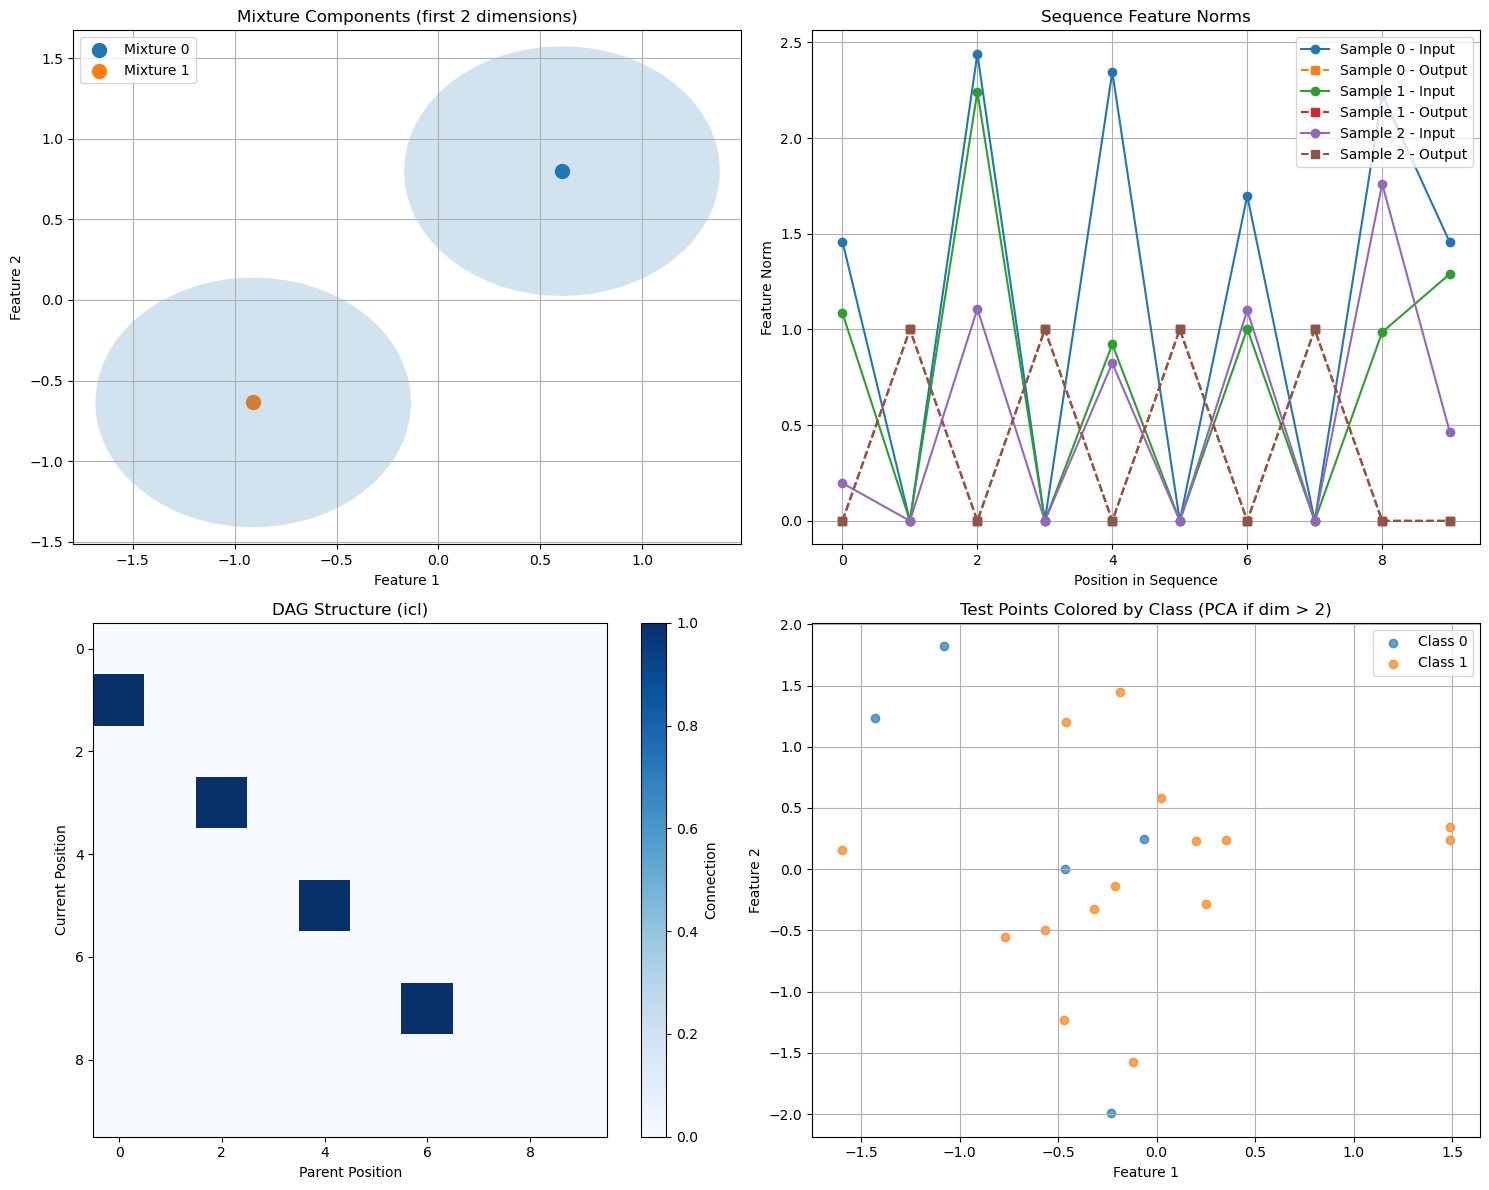

(<problems.InContextTree at 0x7f922c764510>,
 [Array([[ 1.3616685 ,  0.5262135 ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ,  0.        ],
         [-0.70821744,  2.3362122 ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ],
         [ 2.3347516 , -0.23066536,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ,  0.        ],
         [-0.17189232,  1.6896863 ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ],
         [ 2.17845   , -0.46689624,  0.        ,  0.        ],
         [-0.1851066 ,  1.4451549 ,  0.        ,  0.        ]],      dtype=float32),
  Array([[-0.79618603,  0.7380457 ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ],
         [-1.3067981 , -1.8225158 ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ,  0.        ],
         [-0.5062102 ,  0.7717262 ,  0.        ,  0

In [3]:
import matplotlib.pyplot as plt
from jax import random as jr
import jax.numpy as jnp
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
from problems import InContextTree, gen_mixture


def visualize_incontext_tree(
    num_features=4,
    num_mixtures=2,
    seq_len=10, 
    alpha=0.1,
    dag_type="icl",
    seed=42,
    num_samples=10,
    plot_mixture=True,
    plot_sequences=True,
    plot_pca=True
):
    """
    Generate and visualize data from InContextTree.
    
    Parameters:
    - num_features: Total number of features (will be divided by 2)
    - num_mixtures: Number of mixture components
    - seq_len: Length of sequences to generate
    - alpha: Smoothing parameter
    - dag_type: Type of DAG structure ('icl' or 'chain')
    - seed: Random seed
    - num_samples: Number of sequences to generate
    - plot_mixture: Whether to plot the mixture components
    - plot_sequences: Whether to plot raw sequences
    - plot_pca: Whether to plot PCA of the sequences
    """
    # Setup RNG
    key = jr.PRNGKey(seed)
    
    # Create DAG structure
    if dag_type.lower() == "chain":
        dag = jnp.arange(seq_len - 1) - 1
    elif dag_type.lower() == "icl":
        dag = jnp.zeros(seq_len - 1, dtype=int) - 1
        dag = dag.at[1::2].set(2 * jnp.arange((seq_len - 1) // 2))
    else:
        raise ValueError(f"Unknown dag_type: {dag_type}")
    
    # Create problem instance
    problem = InContextTree(
        num_features=num_features,
        num_mixtures=num_mixtures,
        dag=dag,
        alpha=alpha,
    )
    
    # Generate mixture components for visualization
    key, subkey1, subkey2 = jr.split(key, 3)
    means, variances = gen_mixture(subkey1, subkey2, num_mixtures, num_features//2)
    
    # Generate samples
    keys = jr.split(key, num_samples)
    samples = [problem.sample(k) for k in keys]
    sequences = [seq for seq, _ in samples]
    labels = [label for _, label in samples]
    
    # Convert to numpy for easier plotting
    sequences_np = np.array([np.array(seq) for seq in sequences])
    labels_np = np.array([np.array(label) for label in labels])
    
    # Start plotting
    plt.figure(figsize=(15, 12))
    
    # 1. Visualize the mixture components if dimensionality allows
    if plot_mixture and num_features//2 >= 2:
        plt.subplot(2, 2, 1)
        for i in range(num_mixtures):
            plt.scatter(means[i, 0], means[i, 1], s=100, label=f"Mixture {i}")
            
            # Plot ellipses representing the covariance
            from matplotlib.patches import Ellipse
            
            # Calculate eigenvalues and eigenvectors for the 2D subspace
            vals, vecs = np.linalg.eigh(variances[i, :2, :2])
            angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
            width, height = 2 * np.sqrt(5.991 * vals)  # 95% confidence interval
            
            ell = Ellipse(xy=(means[i, 0], means[i, 1]),
                          width=width, height=height,
                          angle=angle, alpha=0.2)
            plt.gca().add_patch(ell)
            
        plt.title("Mixture Components (first 2 dimensions)")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.grid(True)
    
    # 2. Visualize raw sequences
    if plot_sequences:
        plt.subplot(2, 2, 2)
        actual_features = num_features // 2
        
        # Plot sequence data: first half vs second half for each position
        for i in range(min(3, num_samples)):  # Show first 3 samples
            seq = sequences_np[i]
            
            # Split each position into input and output parts
            input_features = seq[:, :actual_features]
            output_features = seq[:, actual_features:]
            
            # Calculate norm for visualization
            input_norm = np.linalg.norm(input_features, axis=1)
            output_norm = np.linalg.norm(output_features, axis=1)
            
            plt.plot(np.arange(seq_len), input_norm, 'o-', label=f"Sample {i} - Input")
            plt.plot(np.arange(seq_len), output_norm, 's--', label=f"Sample {i} - Output")
        
        plt.title("Sequence Feature Norms")
        plt.xlabel("Position in Sequence")
        plt.ylabel("Feature Norm")
        plt.legend()
        plt.grid(True)
    
    # 3. Visualize DAG structure
    plt.subplot(2, 2, 3)
    A = np.zeros((seq_len, seq_len))
    idx = np.where(dag >= 0)[0]
    for i, parent in zip(idx, dag[idx]):
        A[i, parent] = 1
    
    plt.imshow(A, cmap='Blues')
    plt.title(f"DAG Structure ({dag_type})")
    plt.xlabel("Parent Position")
    plt.ylabel("Current Position")
    plt.colorbar(label="Connection")
    
    # 4. PCA visualization of input features
    if plot_pca and num_samples >= 3:
        plt.subplot(2, 2, 4)
        
        # Get the test points (last position of each sequence)
        test_inputs = sequences_np[:, -1, :actual_features]
        
        # Get the labels
        label_indices = np.argmax(labels_np[:, actual_features:], axis=1)
        
        # Perform PCA if dimensions > 2
        if actual_features > 2:
            pca = PCA(n_components=2)
            test_inputs_2d = pca.fit_transform(test_inputs)
        else:
            test_inputs_2d = test_inputs
            
        # Plot the test points colored by their label
        for i in range(num_mixtures):
            mask = label_indices == i
            plt.scatter(
                test_inputs_2d[mask, 0], 
                test_inputs_2d[mask, 1], 
                label=f"Class {i}",
                alpha=0.7
            )
            
        plt.title("Test Points Colored by Class (PCA if dim > 2)")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 5. If we have 3D data, show a 3D visualization
    if actual_features >= 3 and plot_pca:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        test_inputs = sequences_np[:, -1, :actual_features]
        
        # If dimensions > 3, apply PCA
        if actual_features > 3:
            pca = PCA(n_components=3)
            test_inputs_3d = pca.fit_transform(test_inputs)
        else:
            test_inputs_3d = test_inputs[:, :3]
            
        # Plot the test points colored by their label
        for i in range(num_mixtures):
            mask = label_indices == i
            ax.scatter(
                test_inputs_3d[mask, 0], 
                test_inputs_3d[mask, 1], 
                test_inputs_3d[mask, 2],
                label=f"Class {i}",
                alpha=0.7
            )
            
        ax.set_title("Test Points in 3D Space")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2") 
        ax.set_zlabel("Feature 3")
        ax.legend()
        plt.show()
    
    return problem, sequences, labels


# Example usage:
visualize_incontext_tree(num_features=4, num_mixtures=2, seq_len=10, num_samples=20)